In [4]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

###### PIMCO GIS Global Hi Yld Bd E Acc EUR H - ISIN IE00B11XZ327 - Mutual Fund

##### vs

######  iShares iBoxx  High Yield Corporate Bond ETF

In [5]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.plotly as py
import plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib.ticker import FuncFormatter
from pandas_datareader import data as pdr
from time import gmtime, strftime
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set matplotlib style
plt.style.use('seaborn')

# Set plotly offline
init_notebook_mode(connected=True)

In [6]:
import cufflinks as cf
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [7]:
a = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('A última vez que este script foi executado foi em:', a)

A última vez que este script foi executado foi em: 2017-10-12 14:09:56


In [8]:
#### Functions ####
def compute_drawdowns(dataframe):
    """
    Function to compute drawdowns of a timeseries
    """
    return (dataframe / dataframe.cummax() -1) * 100

In [9]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2007-10-31"
                           
MSid = ['F0GBR06T6D']
Nomes = ['PimcoHY']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

In [10]:
fundos.head()

,PimcoHY
date,
2007-10-31,13.13
2007-11-01,13.11
2007-11-02,13.12
2007-11-05,13.09
2007-11-06,13.10


In [11]:
fundos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2455 entries, 2007-10-31 to 2017-10-11
Data columns (total 1 columns):
PimcoHY    2455 non-null float64
dtypes: float64(1)
memory usage: 38.4 KB


In [13]:
# download quotes
tickers = ['HYG']
Quotes = pd.DataFrame()
Start ='2007-10-31'

for t in tickers:
    Quotes[t] = pdr.get_data_yahoo(t, start=Start)['Adj Close']

In [14]:
Quotes.head()

,HYG
Date,
2007-10-31,51.882698
2007-11-01,51.545746
2007-11-02,51.420036
2007-11-05,51.394894
2007-11-06,51.661442


In [15]:
Quotes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2506 entries, 2007-10-31 to 2017-10-12
Data columns (total 1 columns):
HYG    2506 non-null float64
dtypes: float64(1)
memory usage: 39.2 KB


In [16]:
Quotes_df = Quotes.merge(fundos, left_index = True, right_index = True, how='outer')

In [17]:
Quotes_df.head()

,HYG,PimcoHY
2007-10-31,51.882698,13.13
2007-11-01,51.545746,13.11
2007-11-02,51.420036,13.12
2007-11-05,51.394894,13.09
2007-11-06,51.661442,13.10


In [18]:
Quotes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2506 entries, 2007-10-31 to 2017-10-12
Data columns (total 2 columns):
HYG        2506 non-null float64
PimcoHY    2455 non-null float64
dtypes: float64(2)
memory usage: 58.7 KB


In [19]:
# Reordering the columns
Quotes_df = Quotes_df[['PimcoHY', 'HYG']]

In [20]:
Quotes_df = Quotes_df.fillna(method='ffill')

In [21]:
Quotes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2506 entries, 2007-10-31 to 2017-10-12
Data columns (total 2 columns):
PimcoHY    2506 non-null float64
HYG        2506 non-null float64
dtypes: float64(2)
memory usage: 58.7 KB


In [22]:
#### Returns ####
returns = (Quotes_df / Quotes_df.shift(1)) - 1

In [23]:
#### Normalization to 100 ####
Quotes_df_norm = round((Quotes_df / Quotes_df.iloc[0] * 100), 2)

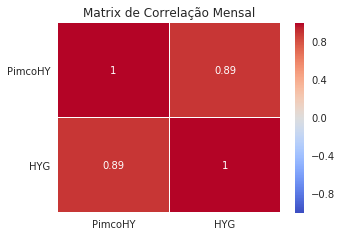

In [24]:
#### Get monthly returns for correlation matrix
Quotes_monthly = Quotes_df_norm.resample('BM').last().copy()
Returns_monthly = (Quotes_monthly / Quotes_monthly.shift(1)) - 1

##### New Preturns (to include Portfolio returns) ####
Preturns = Returns_monthly.copy()

##### Correlation (bonus: Seaborn heatmap)####
Pcorr_matrix = Preturns.corr()
a = -0.5

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 3.5) # 68%
sns.heatmap(Pcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin=-1)
plt.yticks(rotation=360)
plt.title('Matrix de Correlação Mensal')
plt.show()

In [25]:
Quotes_df_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos')

In [26]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(Quotes_df_norm), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem')

In [27]:
Quotes_df_norm.head()

,PimcoHY,HYG
2007-10-31,100.00,100.00
2007-11-01,99.85,99.35
2007-11-02,99.92,99.11
2007-11-05,99.70,99.06
2007-11-06,99.77,99.57


In [28]:
Quotes_monthly = Quotes_df_norm.resample('BM').last().copy()

In [29]:
Quotes_monthly.head()

,PimcoHY,HYG
2007-10-31,100.00,100.00
2007-11-30,99.47,98.88
2007-12-31,99.77,98.79
2008-01-31,99.24,96.99
2008-02-29,98.32,95.18


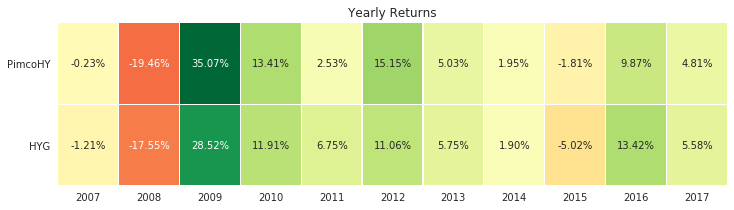

In [30]:
# Resampling to yearly (business year)
yearly_quotes = Quotes_df_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([Quotes_df_norm.iloc[:1], yearly_quotes])

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(2006, 2018))]).drop(2006)

#### Inverter o sentido das rows no dataframe ####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12, 3) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()